In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.formula.api import ols
from sklearn import metrics

In [2]:
df = pd.read_csv('datasets/base_train.csv')

In [3]:
df.drop(columns='Unnamed: 0', inplace=True)

In [4]:
df.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,0.0,13517,Pave,None,IR1,Lvl,...,0,0,None,None,None,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,None,IR1,Lvl,...,0,0,None,None,None,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,None,Reg,Lvl,...,0,0,None,None,None,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,None,Reg,Lvl,...,0,0,None,None,None,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,None,IR1,Lvl,...,0,0,None,None,None,0,3,2010,WD,138500


In [5]:
int_cols = [col for col in df.columns if df[col].dtype == 'int']

In [6]:
float_cols = [col for col in df.columns if df[col].dtype == 'float']

In [7]:
len(int_cols)

28

In [8]:
len(float_cols)

11

In [9]:
float_cols

['lot_frontage',
 'mas_vnr_area',
 'bsmtfin_sf_1',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'garage_yr_blt',
 'garage_cars',
 'garage_area']

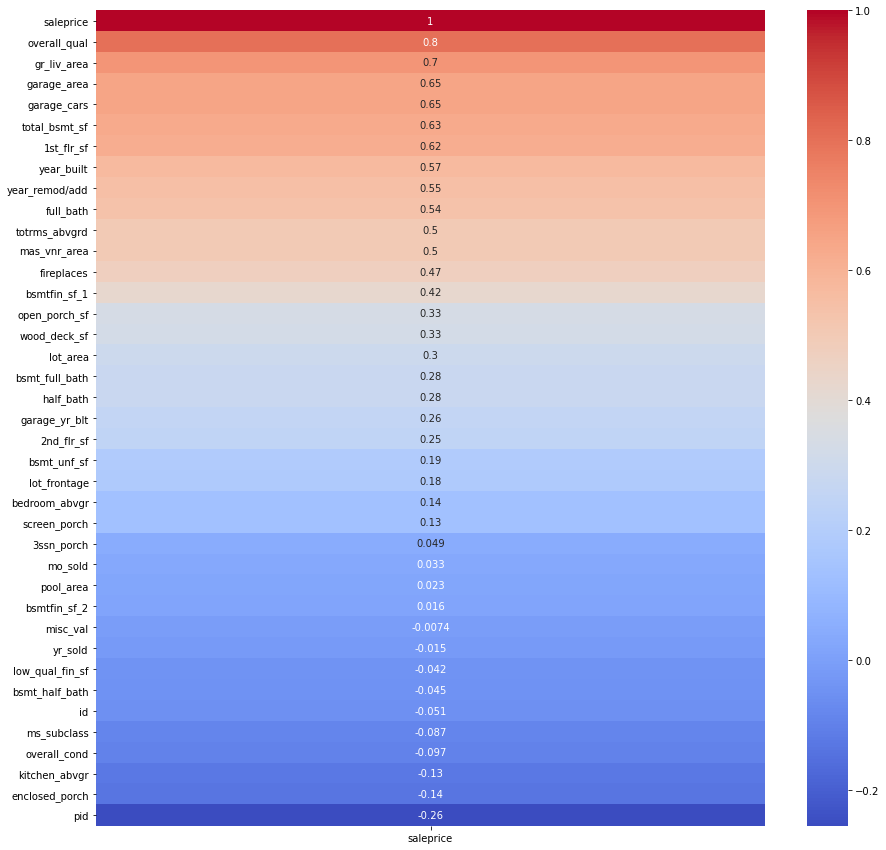

In [10]:
plt.figure(figsize=(15, 15))
plt.fontsize = 27
sns.heatmap(df.corr()[['saleprice']].sort_values('saleprice', ascending=False), annot=True, cmap='coolwarm', vmax=1);

In [11]:
# i_feats equals the columns I want to include as my dependent variables that are ints
# going to attempt to explore each int column
i_feats = []

In [12]:
#all columns that need outliers removed, or dtype changed 
needs_fix = []

In [13]:
#will return scatter plot of column vs saleprice if column is an int
# will only keep cell and append to i_feats if relationship seems worthy
def investigate(col):
    if df[col].dtype == 'int' or df[col].dtype == 'float':
        scatt = plt.scatter(df[col], df['saleprice'])
        plt.xlabel(col)
        plt.ylabel('saleprice')
        plt.title(col + ' by saleprice')
        return scatt
    else:
        return(f'{col} is not an int or float')

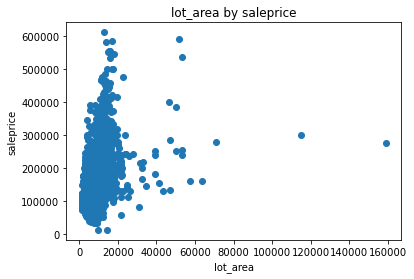

In [14]:
# 'lot_area' corr to saleprice seems somewhat strong, the outliers are an issue and will need to change them, potentially change them to the mean 
investigate(int_cols[3]);
i_feats.append(int_cols[3])

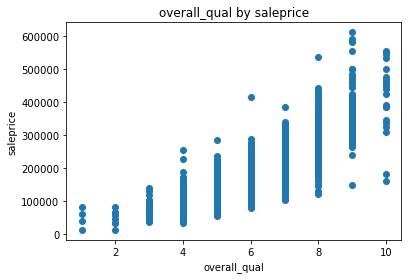

In [15]:
#nice strong positive relationship here, increase in overall_qual leads to increase in saleprice
investigate(int_cols[4])
i_feats.append(int_cols[4])

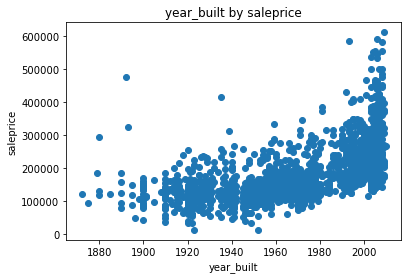

In [16]:
#skewed left, def a relationship worth including, relatively strong positive corr to saleprice
#might need to transform and get rid of the outliers, some houses built in early 1900's and late 1800's have high prices,
investigate(int_cols[6])
i_feats.append(int_cols[6])

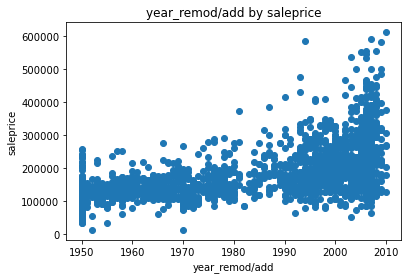

In [17]:
#might be a better fit than 'year built', will have to explore both 'year_remod/add' and 'year_built' and decide how to include them
investigate(int_cols[7])
i_feats.append(int_cols[7])

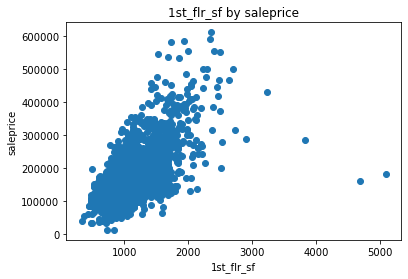

In [18]:
#1st_flr_sf seems to have a strong corr to saleprice, however the outliers need to be changed, will throw off the coef
investigate(int_cols[8])
i_feats.append(int_cols[8])

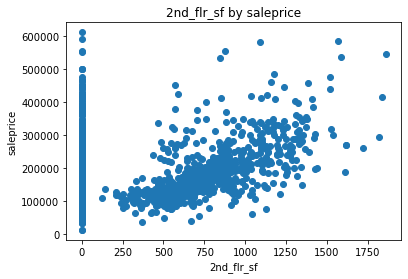

In [19]:
#need to do something with the 2nd_flr_sf 0s, this is a good corr but the 0s will throw off the coef
investigate(int_cols[9])
needs_fix.append(int_cols[9])
i_feats.append(int_cols[9])

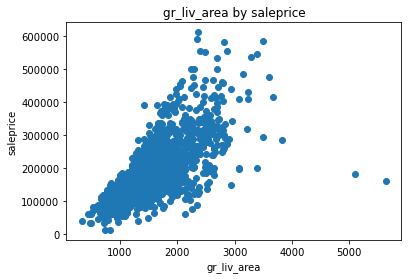

In [20]:
#strong positive relationship between gr_liv_area and saleprice
#need to deal with these outliers
investigate(int_cols[11])
i_feats.append(int_cols[11])
needs_fix.append(int_cols[11])

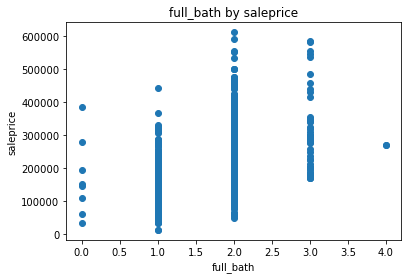

In [21]:
#somewhat strong corr here to saleprice, however, 0s could mean its an empty lot and need to deal with the one outlier
investigate(int_cols[12])
i_feats.append(int_cols[12])

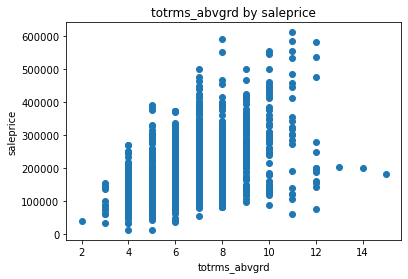

In [22]:
#somewhat of a positive relationship here, need to deal with the outliers 
investigate(int_cols[16])
i_feats.append(int_cols[16])
needs_fix.append(int_cols[16])

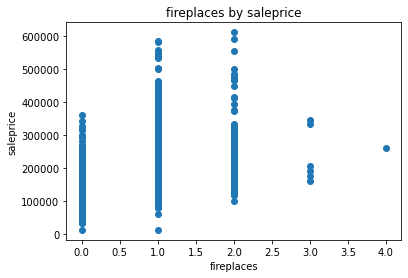

In [23]:
#slight positive relationship to saleprice
#needs a lot of transformation before adding to model
investigate(int_cols[17])
needs_fix.append(int_cols[17])

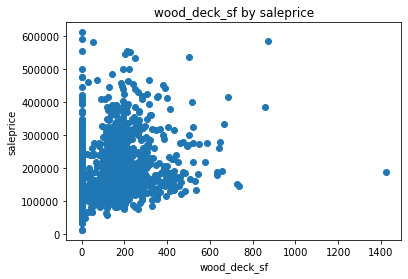

In [24]:
#looks like some corr to saleprice, would need to deal with the 0s first before adding to model
investigate(int_cols[18])
needs_fix.append(int_cols[18])

In [25]:
i_feats

['lot_area',
 'overall_qual',
 'year_built',
 'year_remod/add',
 '1st_flr_sf',
 '2nd_flr_sf',
 'gr_liv_area',
 'full_bath',
 'totrms_abvgrd']

In [26]:
needs_fix

['2nd_flr_sf', 'gr_liv_area', 'totrms_abvgrd', 'fireplaces', 'wood_deck_sf']

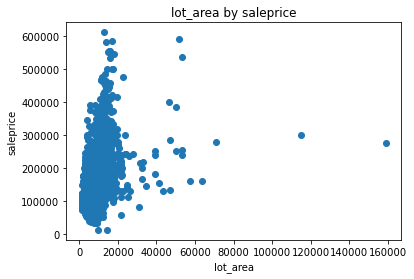

In [28]:
#Could be strong positive corr to saleprice if outliers are removed, worth including
investigate(i_feats[0])

In [47]:
#max lot_area is an extreme outlier
df['lot_area'].describe()

count      2051.000000
mean      10065.208191
std        6742.488909
min        1300.000000
25%        7500.000000
50%        9430.000000
75%       11513.500000
max      159000.000000
Name: lot_area, dtype: float64

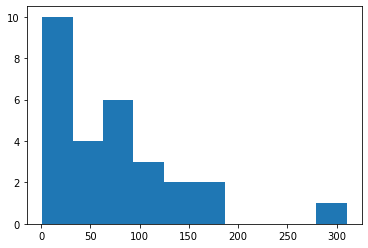

In [32]:
#not normally distributed, some neighborhoods have very small value_counts while others have significantly more
#if included, coefs will throw off model
plt.hist(df['neighborhood'].value_counts());